# Train or Rather Fine-Tune a Model

First model to test for this job: ResNet18

I will first start with training the models locally.
ResNet18 is relative lightweight, but still powerful, and suited for training
locally on my machine.
If that one doesn't do the job, I will try larger models.
In case I need more compute, I will switch to a remote host.
Also, my data set contains about 6000 images, which is not that large.
A smaller model may be more suitable for transfer learning here.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
# FIXME
# delete this cell - it was used for checking
# result: mps is available and I can use GPU accelleration on my Mac

# check if MPS (Metal Performance Shaders) is available on your Mac
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"using device: {device}")

using device: mps


In [12]:
# Paths
PATH_DATA_PROCESSED = Path("../data/processed")
PATH_DATA_TRAIN = PATH_DATA_PROCESSED / "train"
PATH_DATA_TEST = PATH_DATA_PROCESSED / "test"

In [13]:
# define image transformations - simplified first
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def custom_loader(path):
    """Custom image loader that forces image reading in RGB mode."""
    try:
        # force RGB mode during initial open
        img = Image.open(path).convert("RGB")
        return img
    except Exception as e:
        print(f"error loading image {path}: {str(e)}")
        # return a blank RGB image as fallback
        return Image.new("RGB", (224, 224), "white")

# recreate datasets with new loader and transforms
train_dataset = datasets.ImageFolder(
    PATH_DATA_TRAIN,
    loader=custom_loader,
    transform=transform
)
test_dataset = datasets.ImageFolder(
    PATH_DATA_TEST,
    loader=custom_loader,
    transform=transform
)

In [14]:
# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [15]:
# print some basic info
print(f"number of training images: {len(train_dataset)}")
print(f"number of test images: {len(test_dataset)}")
print(f"classes: {train_dataset.classes}")

number of training images: 4730
number of test images: 1183
classes: ['chihuahua', 'muffin']


In [16]:
# load pre-trained ResNet18
model = models.resnet18(weights="IMAGENET1K_V1")

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: muffin and chihuahua

# move model to GPU
model = model.to(device)

In [17]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# only optimize the parameters of the final layer since others are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# test the training loop for one epoch
epoch_loss, epoch_acc = train_one_epoch(
    model,
    train_loader,
    criterion,
    optimizer,
    device
)
print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Loss: 0.1432, Accuracy: 94.97%


In [19]:
def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return val_loss / len(val_loader), 100. * correct / total

# number of epochs to train for
n_epochs = 5

# training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(n_epochs):
    # train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    
    # store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("-" * 50)

Epoch 1/5:
Train Loss: 0.0612, Train Acc: 97.86%
Val Loss: 0.0353, Val Acc: 98.90%
--------------------------------------------------
Epoch 2/5:
Train Loss: 0.0515, Train Acc: 98.22%
Val Loss: 0.0410, Val Acc: 98.73%
--------------------------------------------------
Epoch 3/5:
Train Loss: 0.0369, Train Acc: 98.54%
Val Loss: 0.0439, Val Acc: 98.56%
--------------------------------------------------
Epoch 4/5:
Train Loss: 0.0388, Train Acc: 98.52%
Val Loss: 0.0278, Val Acc: 98.90%
--------------------------------------------------
Epoch 5/5:
Train Loss: 0.0324, Train Acc: 98.82%
Val Loss: 0.0263, Val Acc: 99.07%
--------------------------------------------------


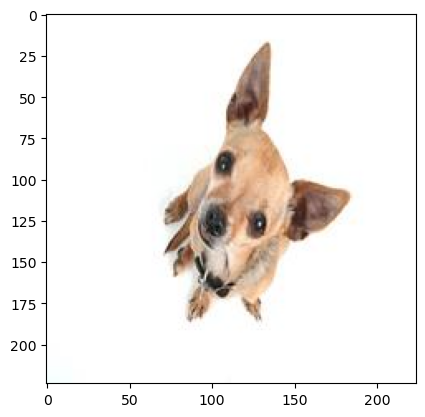

Prediction: chihuahua with 99.99% confidence


In [26]:
def predict_image(model, image_path, device):
    """Predict a single image."""
    
    # set model to evaluation mode
    model.eval()
    
    # load and display image
    img = custom_loader(image_path)
    plt.imshow(img)
    plt.show()

    # preprocess the image
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # get prediction
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.nn.functional.softmax(output, dim=1)
        pred_idx = output.argmax(dim=1).item()
    
    # get class name and probability
    class_name = train_dataset.classes[pred_idx]
    probability = prob[0][pred_idx].item()
    
    return class_name, probability

# example usage:
test_image_path = PATH_DATA_PROCESSED / "test" / "chihuahua" / "img_1_144.jpg"
pred_class, confidence = predict_image(model, test_image_path, device)
print(f"Prediction: {pred_class} with {confidence:.2%} confidence")
